# 导入必要的库

我们需要导入一个叫 [captcha](https://github.com/lepture/captcha/) 的库来生成验证码。

我们生成验证码的字符由数字和大写字母组成。

```sh
pip install captcha numpy matplotlib tensorflow-gpu
```

In [1]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits + string.ascii_uppercase
print(characters)

width, height, n_len, n_class = 128, 64, 4, len(characters)

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


# 防止 tensorflow 占用所有显存

In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

# 定义数据生成器

In [3]:
from tensorflow.keras.utils import Sequence

class CaptchaSequence(Sequence):
    def __init__(self, characters, batch_size, steps, n_len=4, width=128, height=64):
        self.characters = characters
        self.batch_size = batch_size
        self.steps = steps
        self.n_len = n_len
        self.width = width
        self.height = height
        self.n_class = len(characters)
        self.generator = ImageCaptcha(width=width, height=height)
    
    def __len__(self):
        return self.steps

    def __getitem__(self, idx):
        X = np.zeros((self.batch_size, self.height, self.width, 3), dtype=np.float32)
        y = [np.zeros((self.batch_size, self.n_class), dtype=np.uint8) for i in range(self.n_len)]
        for i in range(self.batch_size):
            random_str = ''.join([random.choice(self.characters) for j in range(self.n_len)])
            X[i] = np.array(self.generator.generate_image(random_str)) / 255.0
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, self.characters.find(ch)] = 1
        return X, y

# 测试生成器

Text(0.5,1,'RJI4')

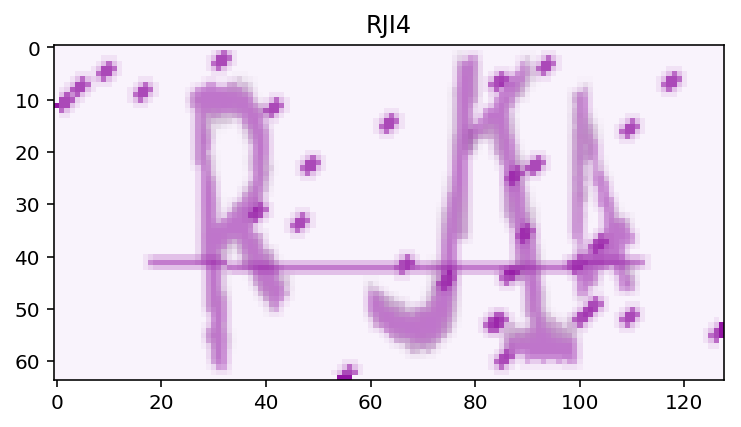

In [4]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

data = CaptchaSequence(characters, batch_size=1, steps=1)
X, y = data[0]
plt.imshow(X[0])
plt.title(decode(y))

# 定义网络结构

In [5]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i, n_cnn in enumerate([2, 2, 2, 2, 2]):
    for j in range(n_cnn):
        x = Conv2D(32*2**min(i, 3), kernel_size=3, padding='same', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]
model = Model(inputs=input_tensor, outputs=x)

Instructions for updating:
Colocations handled automatically by placer.


# 网络结构可视化

可视化需要安装下面的包：

```sh
pip install pydot
sudo apt install graphviz
```

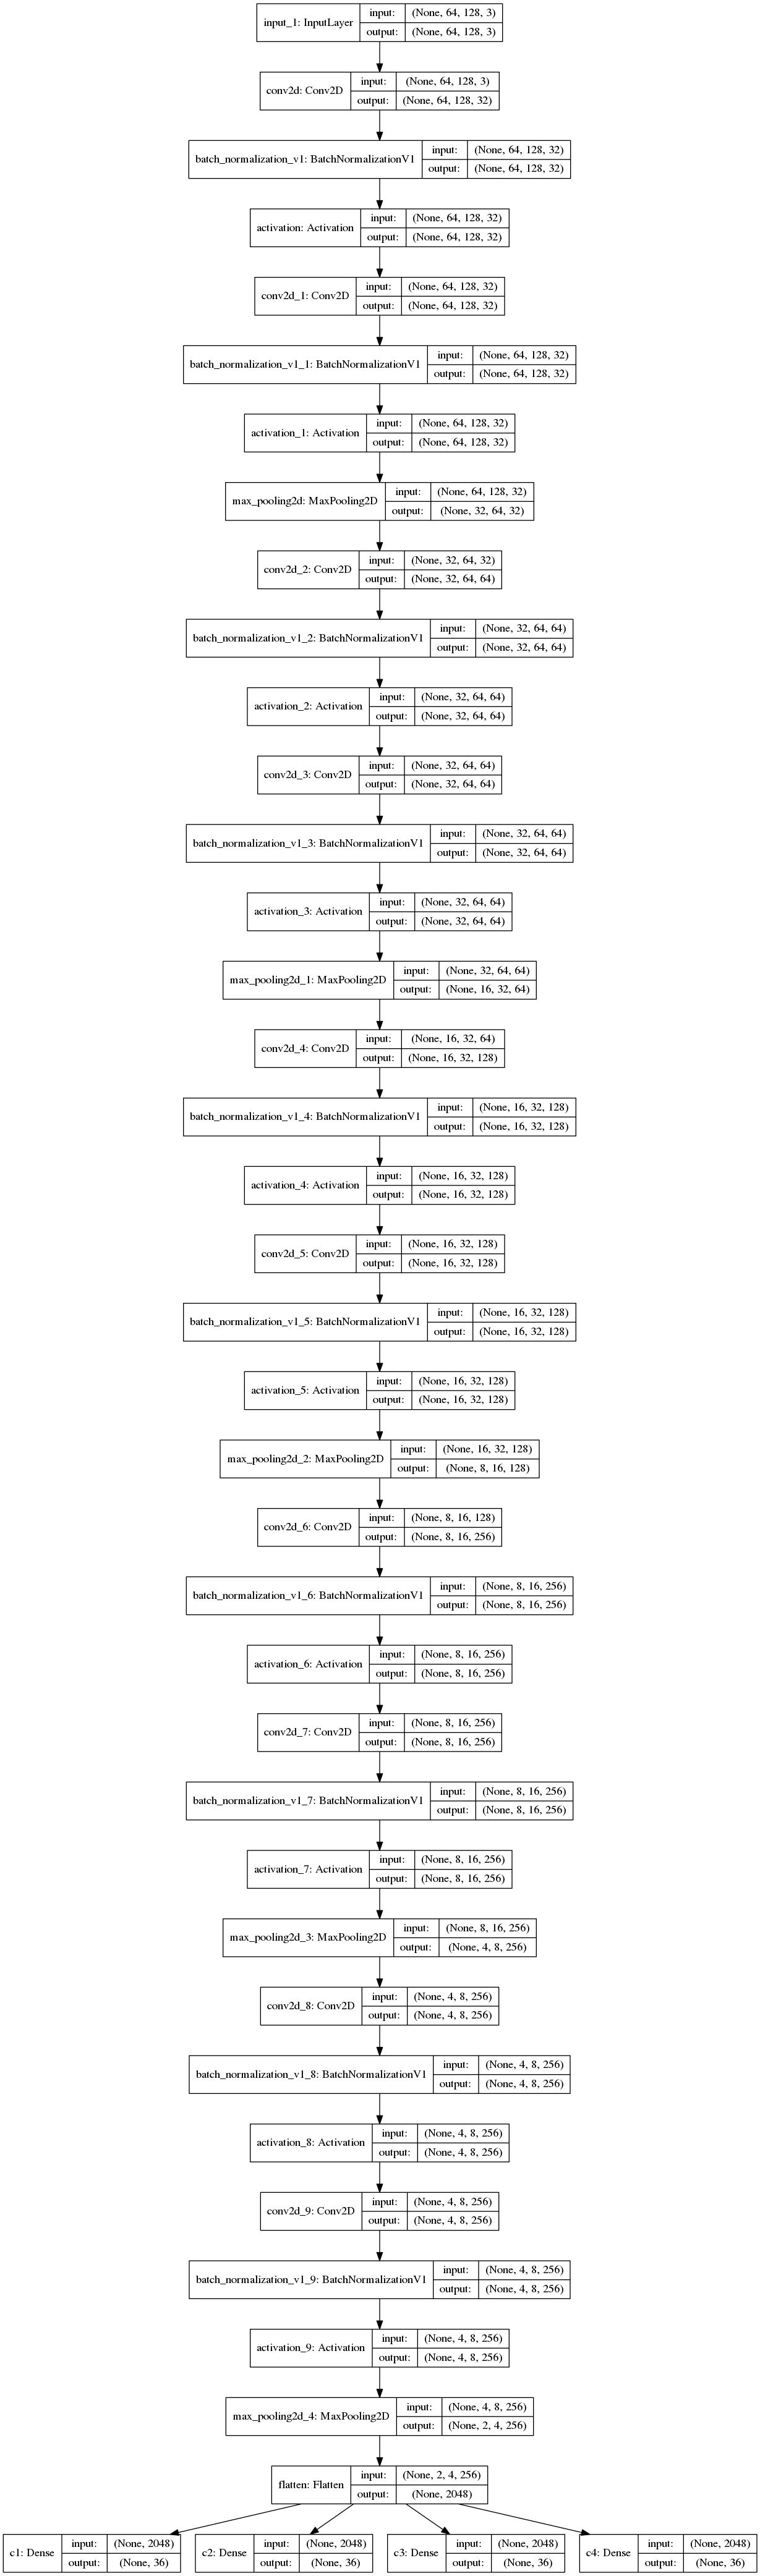

In [6]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='cnn.png', show_shapes=True)
Image('cnn.png')

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 128, 3)   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 128, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 64, 128, 32)  128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 128, 32)  0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

# 训练模型

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import *

train_data = CaptchaSequence(characters, batch_size=128, steps=1000)
valid_data = CaptchaSequence(characters, batch_size=128, steps=100)
callbacks = [EarlyStopping(patience=3), CSVLogger('cnn.csv'), ModelCheckpoint('cnn_best.h5', save_best_only=True)]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-3, amsgrad=True), 
              metrics=['accuracy'])
model.fit_generator(train_data, epochs=100, validation_data=valid_data, workers=4, use_multiprocessing=True,
                    callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1000/1000 [==============================] - 117s 117ms/step - loss: 5.1894 - c1_loss: 1.2421 - c2_loss: 1.3584 - c3_loss: 1.3576 - c4_loss: 1.2314 - c1_acc: 0.6572 - c2_acc: 0.6260 - c3_acc: 0.6268 - c4_acc: 0.6603 - val_loss: 0.5755 - val_c1_loss: 0.1017 - val_c2_loss: 0.1806 - val_c3_loss: 0.1910 - val_c4_loss: 0.1022 - val_c1_acc: 0.9613 - val_c2_acc: 0.9398 - val_c3_acc: 0.9373 - val_c4_acc: 0.9626
Epoch 2/100
1000/1000 [==============================] - 124s 124ms/step - loss: 0.3010 - c1_loss: 0.0589 - c2_loss: 0.0892 - c3_loss: 0.0908 - c4_loss: 0.0621 - c1_acc: 0.9769 - c2_acc: 0.9674 - c3_acc: 0.9669 - c4_acc: 0.9763 - val_loss: 0.3528 - val_c1_loss: 0.0927 - val_c2_loss: 0.0852 - val_c3_loss: 0.1172 - val_c4_loss: 0.0577 - val_c1_acc: 0.9692 - val_c2_acc: 0.9684 - val_c3_acc: 0.9626 - val_c4_acc: 0.9774
Epoch 3/100
1000/1000 [==============================] - 124s 124ms/step - loss: 0.2053 - c1_loss: 0.0435 - c2_los

Epoch 13/100
1000/1000 [==============================] - 119s 119ms/step - loss: 0.0767 - c1_loss: 0.0165 - c2_loss: 0.0208 - c3_loss: 0.0224 - c4_loss: 0.0169 - c1_acc: 0.9936 - c2_acc: 0.9921 - c3_acc: 0.9914 - c4_acc: 0.9931 - val_loss: 0.0880 - val_c1_loss: 0.0201 - val_c2_loss: 0.0258 - val_c3_loss: 0.0234 - val_c4_loss: 0.0188 - val_c1_acc: 0.9929 - val_c2_acc: 0.9903 - val_c3_acc: 0.9911 - val_c4_acc: 0.9927
Epoch 14/100
1000/1000 [==============================] - 125s 125ms/step - loss: 0.0760 - c1_loss: 0.0174 - c2_loss: 0.0196 - c3_loss: 0.0217 - c4_loss: 0.0173 - c1_acc: 0.9930 - c2_acc: 0.9928 - c3_acc: 0.9915 - c4_acc: 0.9934 - val_loss: 0.1016 - val_c1_loss: 0.0195 - val_c2_loss: 0.0286 - val_c3_loss: 0.0259 - val_c4_loss: 0.0276 - val_c1_acc: 0.9925 - val_c2_acc: 0.9895 - val_c3_acc: 0.9897 - val_c4_acc: 0.9899
Epoch 15/100
1000/1000 [==============================] - 124s 124ms/step - loss: 0.0700 - c1_loss: 0.0151 - c2_loss: 0.0192 - c3_loss: 0.0191 - c4_loss: 0.0167

### 载入最好的模型继续训练一会

In [9]:
model.load_weights('cnn_best.h5')

callbacks = [EarlyStopping(patience=3), CSVLogger('cnn.csv', append=True), 
             ModelCheckpoint('cnn_best.h5', save_best_only=True)]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-4, amsgrad=True), 
              metrics=['accuracy'])
model.fit_generator(train_data, epochs=100, validation_data=valid_data, workers=4, use_multiprocessing=True,
                    callbacks=callbacks)

Epoch 1/100
1000/1000 [==============================] - 128s 128ms/step - loss: 0.0586 - c1_loss: 0.0135 - c2_loss: 0.0160 - c3_loss: 0.0155 - c4_loss: 0.0136 - c1_acc: 0.9946 - c2_acc: 0.9937 - c3_acc: 0.9940 - c4_acc: 0.9948 - val_loss: 0.0601 - val_c1_loss: 0.0147 - val_c2_loss: 0.0165 - val_c3_loss: 0.0169 - val_c4_loss: 0.0120 - val_c1_acc: 0.9951 - val_c2_acc: 0.9939 - val_c3_acc: 0.9935 - val_c4_acc: 0.9952
Epoch 2/100
1000/1000 [==============================] - 125s 125ms/step - loss: 0.0550 - c1_loss: 0.0118 - c2_loss: 0.0153 - c3_loss: 0.0152 - c4_loss: 0.0127 - c1_acc: 0.9954 - c2_acc: 0.9942 - c3_acc: 0.9940 - c4_acc: 0.9949 - val_loss: 0.0578 - val_c1_loss: 0.0118 - val_c2_loss: 0.0172 - val_c3_loss: 0.0156 - val_c4_loss: 0.0132 - val_c1_acc: 0.9956 - val_c2_acc: 0.9928 - val_c3_acc: 0.9937 - val_c4_acc: 0.9948
Epoch 3/100
1000/1000 [==============================] - 118s 118ms/step - loss: 0.0527 - c1_loss: 0.0119 - c2_loss: 0.0144 - c3_loss: 0.0149 - c4_loss: 0.0115 - 

In [10]:
model.load_weights('cnn_best.h5')

# 测试模型

(-0.5, 127.5, 63.5, -0.5)

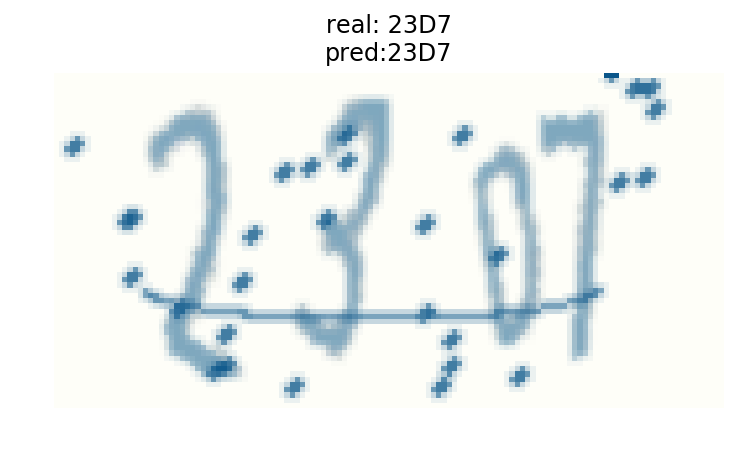

In [11]:
X, y = data[0]
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

# 计算模型总体准确率

In [12]:
from tqdm import tqdm
def evaluate(model, batch_num=100):
    batch_acc = 0
    with tqdm(CaptchaSequence(characters, batch_size=128, steps=100)) as pbar:
        for X, y in pbar:
            y_pred = model.predict(X)
            y_pred = np.argmax(y_pred, axis=-1).T
            y_true = np.argmax(y, axis=-1).T

            batch_acc += (y_true == y_pred).all(axis=-1).mean()
    return batch_acc / batch_num

evaluate(model)

100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


0.98265625

# 保存模型

In [13]:
model.save('cnn.h5', include_optimizer=False)

# 可视化训练曲线

```sh
pip install pandas
```

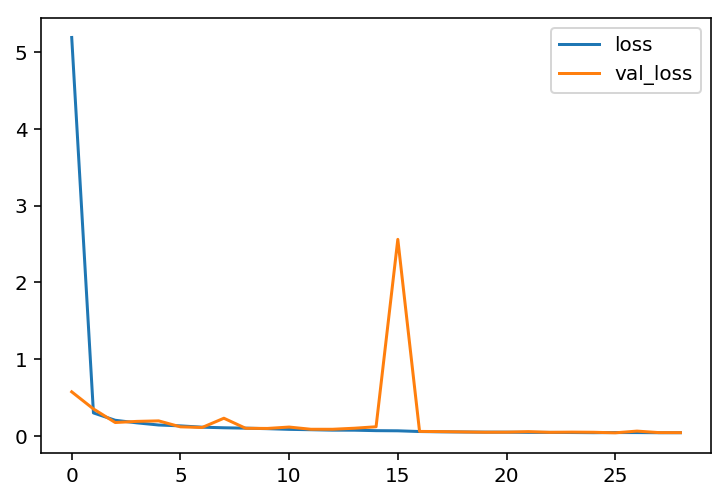

In [14]:
import pandas as pd

df = pd.read_csv('cnn.csv')
df[['loss', 'val_loss']].plot()

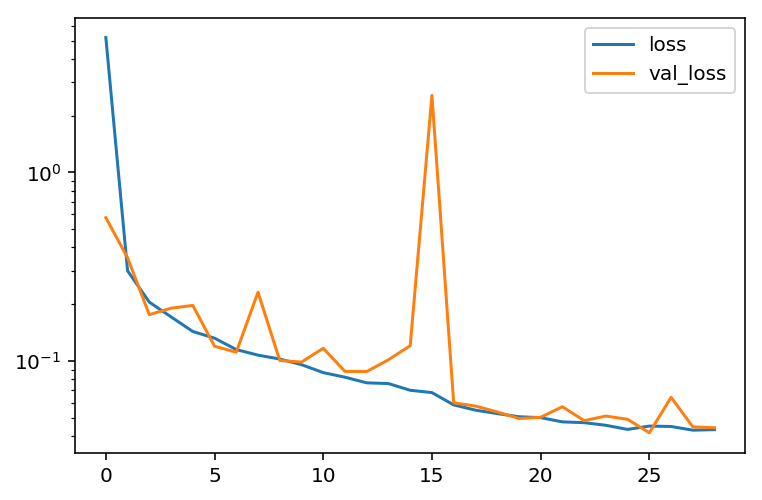

In [15]:
df[['loss', 'val_loss']].plot(logy=True)